In [84]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import sys


from config import BASE_DIR
print(os.getcwd())
os.chdir(BASE_DIR)
print(BASE_DIR)
import scripts.functions as fn



C:\Users\lbisa\Dropbox\Cripto\python\InvestingEvolution\ie\www
C:\Users\lbisa\Dropbox\Cripto\python\InvestingEvolution\ie\www


In [85]:
#klines_file =  './backtest/klines/2d01/Completo_BTCUSDT_2d01_2021-01-01_2023-07-31.DataFrame'
klines_file = './backtest/klines/2d01/Lateral_BTCUSDT_2d01_2023-06-20_2023-10-09.DataFrame'
#klines_file = './backtest/klines/1h01/Completo_BTCUSDT_1h01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m15/Completo_XRPUSDT_0m15_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m01/Completo_BTCUSDT_0m01_2021-01-01_2023-07-31.DataFrame'

with open(klines_file, 'rb') as file:
    df = pickle.load(file)

start_date = klines_file.split('/')[4].split('_')[3] #Extrae la fecha de inicio
start_date = pd.to_datetime(start_date, format='%Y-%m-%d')
start_date = start_date.replace(hour=0, minute=0, second=0)


In [86]:

import plotly.graph_objects as go
from smartmoneyconcepts.smc import smc
from zigzag import core

fig = go.Figure(
    data=[
        go.Candlestick(
            x=df["datetime"],
            open=df["open"],
            high=df["high"],
            low=df["low"],
            close=df["close"],
        )
    ]
)


In [87]:


def add_FVG(fig):
    fvg_data = smc.fvg(df)
    # plot a rectangle for each fvg
    for i in range(len(fvg_data["FVG"])):
        if fvg_data["FVG"][i] != 0:
            x1 = (
                fvg_data["MitigatedIndex"][i]
                if fvg_data["MitigatedIndex"][i] != 0
                else len(df) - 1
            )
            fig.add_shape(
                # filled Rectangle
                type="rect",
                x0=df["datetime"][i],
                y0=fvg_data["Top"][i],
                x1=df["datetime"][x1],
                y1=fvg_data["Bottom"][i],
                line=dict(
                    width=0,
                ),
                fillcolor="yellow",
                opacity=0.5,
            )
    return fig

def add_highs_lows(fig):
    highs_lows_data = smc.highs_lows(df)
    print(highs_lows_data)
    # remove from highs_lows_data
    indexs = []
    levels = []
    for i in range(len(highs_lows_data)):
        if highs_lows_data["HighsLows"][i] != 0:
            indexs.append(i)
            levels.append(highs_lows_data["Levels"][i])
    
    # plot these lines on a graph
    for i in range(len(indexs) - 1):
        fig.add_trace(
            go.Scatter(
                x=[df["datetime"][indexs[i]], df["datetime"][indexs[i + 1]]],
                y=[levels[i], levels[i+1]],
                mode="lines",
                line=dict(
                    color="green" if highs_lows_data["HighsLows"][indexs[i]] == -1 else "red",
                ),
            )
        )

    return fig

def add_OB(fig):
    ob_data = smc.ob(df)

    # plot the same way as FVG
    for i in range(len(ob_data["OB"])):
        if ob_data["OB"][i] == 1:
            x1 = (
                ob_data["MitigatedIndex"][i]
                if ob_data["MitigatedIndex"][i] != 0
                else len(df) - 1
            )
            fig.add_shape(
                type="rect",
                x0=df["datetime"][i],
                y0=ob_data["Top"][i],
                x1=df["datetime"][x1],
                y1=ob_data["Bottom"][i],
                line=dict(
                    width=0,
                ),
                fillcolor="purple",
                opacity=0.5,
            )
    return fig


def add_liquidity(fig):
    liquidity_data = smc.liquidity(df)
    
    # draw a line horizontally for each liquidity level
    for i in range(len(liquidity_data["Liquidity"])):
        if liquidity_data["Liquidity"][i] != 0:
            fig.add_trace(
                go.Scatter(
                    x=[df["datetime"][i], df["datetime"][liquidity_data["End"][i]]],
                    y=[liquidity_data["Level"][i], liquidity_data["Level"][i]],
                    mode="lines",
                    line=dict(
                        color="orange",
                    ),
                )
            )
        if liquidity_data["Swept"][i] != 0:
            # draw a red line between the end and the swept point
            fig.add_trace(
                go.Scatter(
                    x=[
                        df["datetime"][liquidity_data["End"][i]],
                        df["datetime"][liquidity_data["Swept"][i]],
                    ],
                    y=[
                        liquidity_data["Level"][i],
                        (
                            df["high"][liquidity_data["Swept"][i]]
                            if liquidity_data["Liquidity"][i] == 1
                            else df["low"][liquidity_data["Swept"][i]]
                        ),
                    ],
                    mode="lines",
                    line=dict(
                        color="red",
                    ),
                )
            )
    return fig




In [114]:
#fig = add_FVG(fig)
#fig = add_highs_lows(fig)
#fig = add_OB(fig)
#fig = add_liquidity(fig)
#fig.show()

percentage_thresh=0.05
pip_range = max(df["high"]) - min(df["low"])
pip_range = pip_range * percentage_thresh
highs_lows = core.peak_valley_pivots(df["close"], percentage_thresh, -percentage_thresh)
df['hl'] = highs_lows
df['byh'] = 0
df['ph'] = np.where(df['hl']==1,df['high'],None)
df['pl'] = np.where(df['hl']==-1,df['low'],None)
df['op'] = np.where(df['hl']==1,df['close'],0)
df['op'] = np.where(df['hl']==-1,-df['close'],df['op'])



35932.150000000016


C:\Users\lbisa\AppData\Local\Temp\ipykernel_24000\4195873991.py:19: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,op
5,-16212.91
21,17803.15
26,-16438.88
67,23742.30
79,-21625.19
89,24842.20
107,-20150.69
142,30466.93
149,-27262.84
163,29505.61


<Axes: >

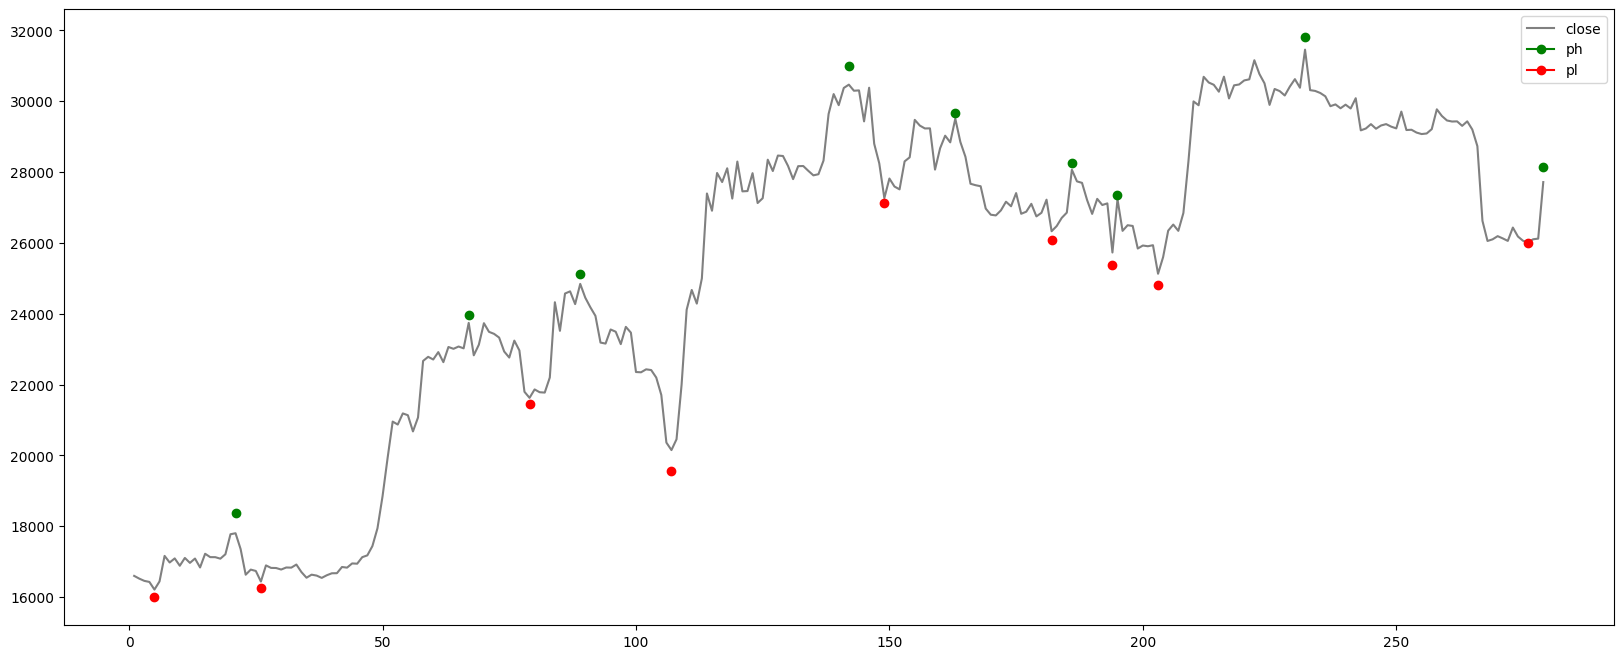

In [112]:
df[['close','ph','pl']].plot(figsize=(20,8),style=['gray','g-o','r-o'])